In [15]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
ref = md.load('protein.pdb', top='protein.psf')

In [6]:
t = md.load('run10.dcd', top='protein.psf')

In [48]:
nrun = 10
for irun in range(nrun):
    t = md.load(f'run{irun+1}.dcd', top='protein.psf')

In [8]:
def compute_drmsds(ref, traj):
    #PHF beta residue indices
    beta_selections = []
    beta_selections.append(" and residue 306 to 311")
    beta_selections.append(" and residue 313 to 322")
    beta_selections.append(" and residue 327 to 331")
    beta_selections.append(" and residue 336 to 341")
    beta_selections.append(" and residue 343 to 347")
    beta_selections.append(" and residue 349 to 354")
    beta_selections.append(" and residue 356 to 363")
    beta_selections.append(" and residue 368 to 378")

    drmsds = []
    for beta_selection in beta_selections:
        # Select backbone atoms of chain I and chain G
        chain_I_atoms = traj.topology.select('chainid == 8 and backbone' + beta_selection)
        chain_G_atoms = traj.topology.select('chainid == 6 and backbone' + beta_selection)

        # Get pairs of atoms where one is from chain I and the other is from chain G
        atom_pairs = traj.topology.select_pairs(chain_I_atoms, chain_G_atoms)

        # Get pairwise distances
        ref_distances = md.compute_distances(ref, atom_pairs)
        pairwise_distances = md.compute_distances(traj, atom_pairs)

        # Compute dRMSD
        drmsd = np.sqrt(np.mean((pairwise_distances - ref_distances)**2, axis=1))
        
        drmsds.append(drmsd)

    return drmsds

In [9]:
def compute_force(ref, traj):
    ca_atoms = ref.topology.select('chainid == 8 and name == CA')

    #ref_sub = ref.atom_slice(ca_atoms)
    #com = md.compute_center_of_mass(ref_sub)
    #z_ref = com[0, 2]
    z_ref = 24.3827095890411

    traj_sub = traj.atom_slice(ca_atoms)
    com = md.compute_center_of_mass(traj_sub)
    z = com[:, 2]

    z_restraint = np.copy(z)
    steps = 25000000
    max_z = 12.0
    delta_z_per_step = max_z / steps
    steps_per_sample = 5000
    for isample in range(len(z_restraint)):
        z_restraint[isample] = z_ref - (isample+1) * steps_per_sample * delta_z_per_step # + traj.unitcell_lengths[isample, 2]

    K = 30543.2 # kJ/mole/nm^2
    force = 2.0 * K * np.abs(z - z_restraint)
    return force

In [10]:
def compute_moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='same')

In [12]:
drmsds = compute_drmsds(ref, t)
force = compute_force(ref, t)

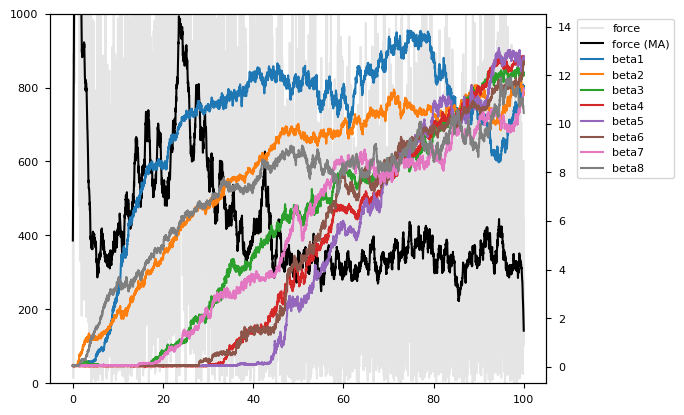

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

time = np.arange(5000) / 50

ln1 = ax1.plot(time, force, 'k', alpha=0.1, label='force')
ln1 = ax1.plot(time, compute_moving_average(force, 50), 'k', label='force (MA)')
ln1 = ax1.set_ylim((0, 1000))

ax2 = ax1.twinx()
for i in range(len(drmsds)):
    ln2 = ax2.plot(time, drmsds[i], label=f'beta{i+1}')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(1.05, 1))

In [36]:
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.minor.pad'] = 4
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['lines.markersize'] = 4

Text(0, 0.5, 'dRMSD [nm]')

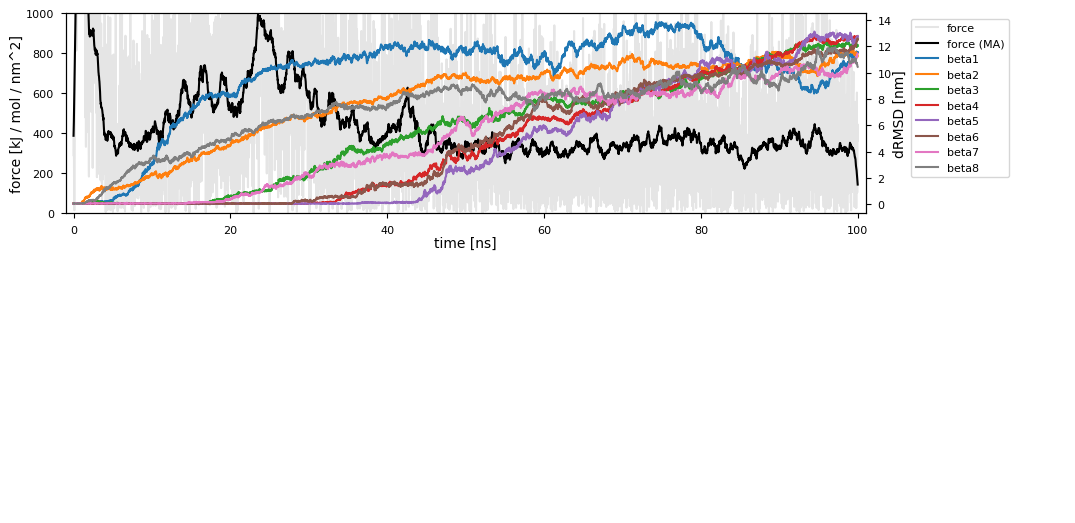

In [45]:
fig = plt.figure(figsize=(10, 5))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()

ax1 = fig.add_subplot(gs[0:2000, 0:8000])

ln1 = ax1.plot(time, force, 'k', alpha=0.1, label='force')
ln1 = ax1.plot(time, compute_moving_average(force, 50), 'k', label='force (MA)')
ln1 = ax1.set_ylim((0, 1000))
ln1 = ax1.set_xlim((-1, 101))

ax2 = ax1.twinx()
for i in range(len(drmsds)):
    ln2 = ax2.plot(time, drmsds[i], label=f'beta{i+1}')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(1.05, 1))
ax1.set_xlabel('time [ns]')
ax1.set_ylabel('force [kJ / mol / nm^2]')
ax2.set_ylabel('dRMSD [nm]')

10000
20000


/var/folders/0l/ydfw5z2x7cg92krt3lj__kfc0000gn/T/ipykernel_81710/1048698827.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('analysis_drmsd_and_force.png', bbox_inches="tight")


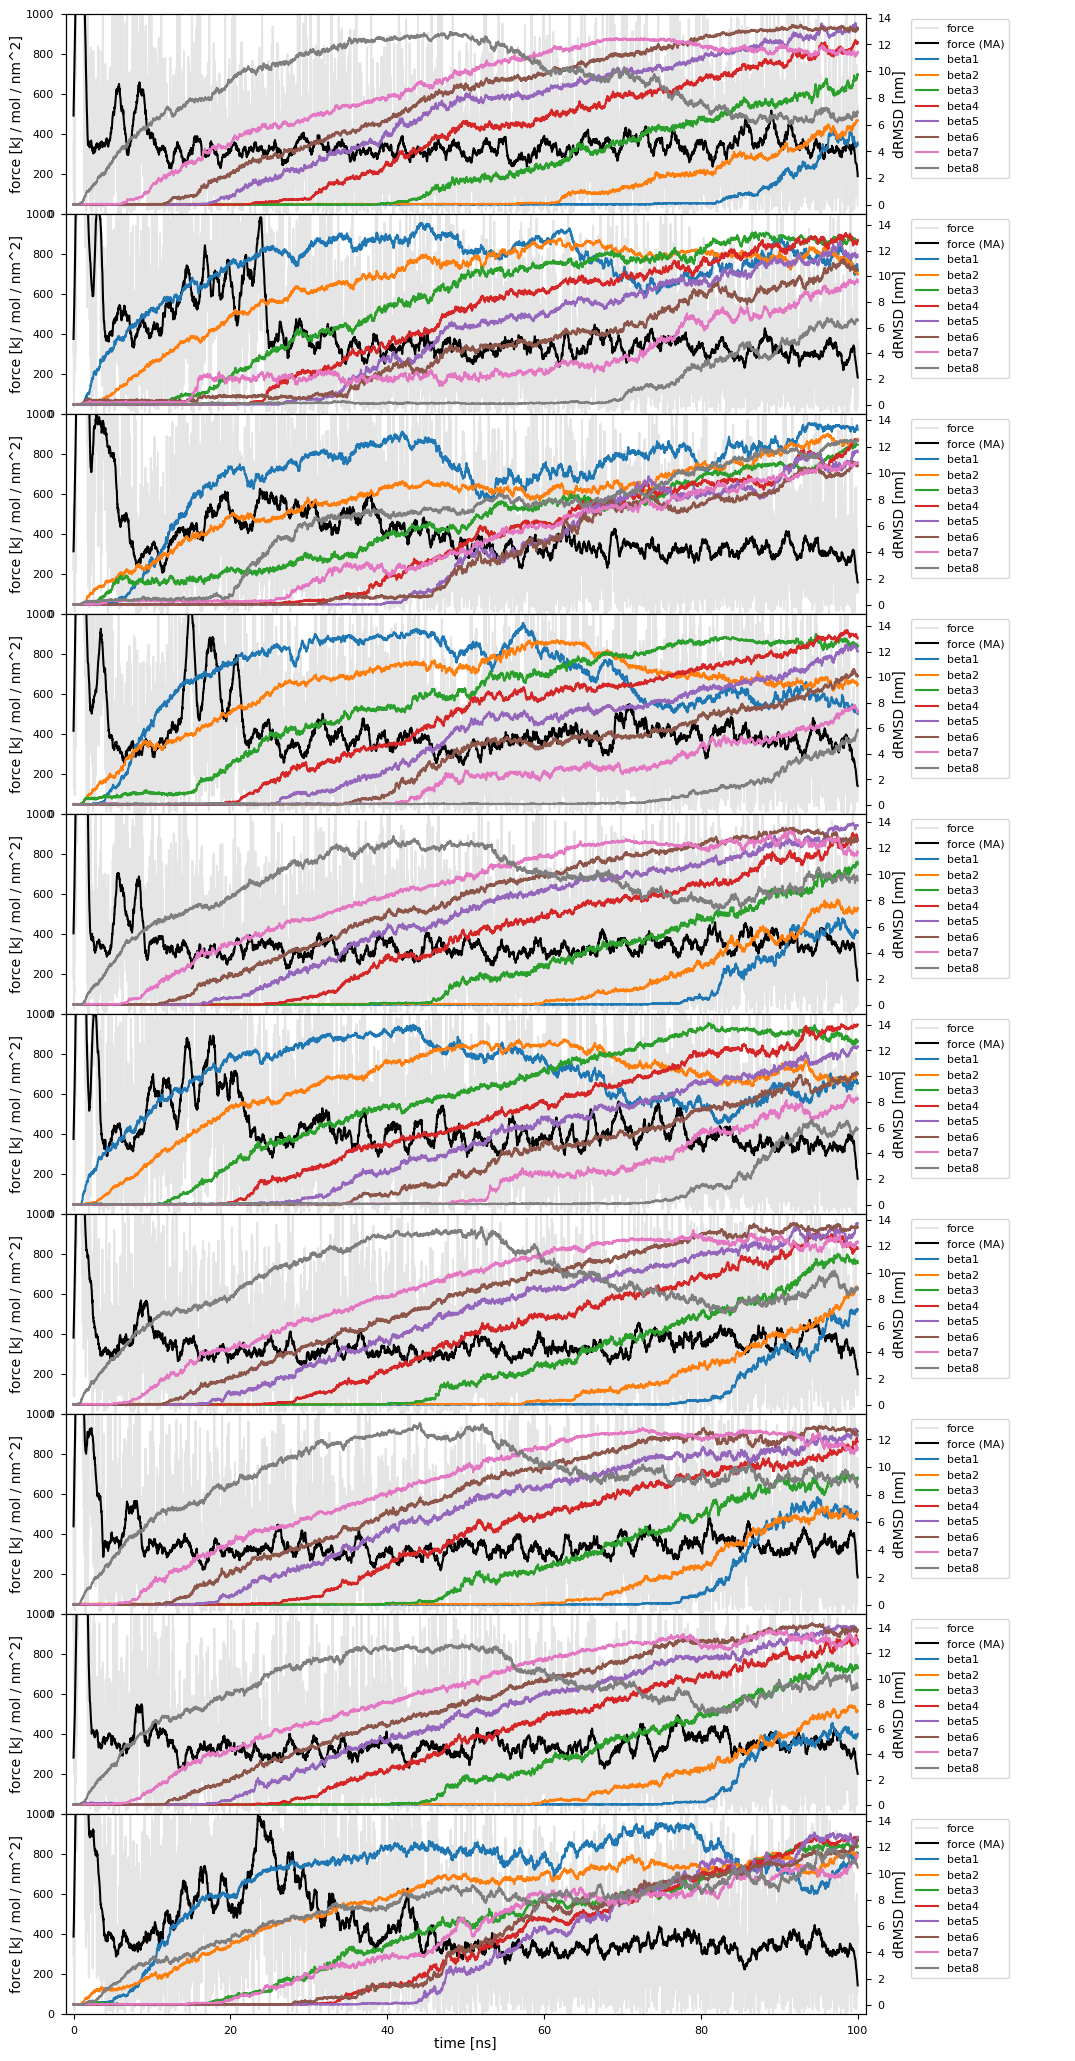

In [57]:
fig = plt.figure(figsize=(10, 20))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
print(gw)
print(gh)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()

for irun in range(nrun):
    t = md.load(f'run{irun+1}.dcd', top='protein.psf')
    drmsds = compute_drmsds(ref, t)
    force = compute_force(ref, t)

    ax1 = fig.add_subplot(gs[2000*irun:2000*(irun+1), 0:8000])

    ln1 = ax1.plot(time, force, 'k', alpha=0.1, label='force')
    ln1 = ax1.plot(time, compute_moving_average(force, 50), 'k', label='force (MA)')
    ln1 = ax1.set_ylim((0, 1000))
    ln1 = ax1.set_xlim((-1, 101))

    ax2 = ax1.twinx()
    for i in range(len(drmsds)):
        ln2 = ax2.plot(time, drmsds[i], label=f'beta{i+1}')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel('time [ns]')
    ax1.set_ylabel('force [kJ / mol / nm^2]')
    ax2.set_ylabel('dRMSD [nm]')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.savefig('analysis_drmsd_and_force.png', bbox_inches="tight")